# Identificación de Elementos Comunes en Anuncios Performantes de TikTok

## Introducción

En este análisis, nos proponemos identificar los elementos comunes en los anuncios de TikTok que han demostrado ser performantes. Estos anuncios, extraídos de los top ads de la plataforma, ofrecen una oportunidad única para entender qué características contribuyen al éxito en términos de engagement y efectividad.

El análisis se centra en dos aspectos principales:

1. Características del Video: Duración, calidad, resolución, tasa de bits, y otros aspectos técnicos que podrían influir en el rendimiento de los anuncios.
2. Elementos Visuales: Objetos y segmentos detectados en los keyframes de los anuncios utilizando el modelo de detección de objetos YOLOv8. Estos elementos visuales incluyen personas, productos, y otros objetos relevantes que podrían captar la atención de la audiencia.

A través de este análisis, buscamos responder las siguientes preguntas:

- ¿Cuáles son los elementos visuales más comunes en los anuncios performantes?
- ¿Existen patrones de co-ocurrencia entre diferentes elementos visuales?
- ¿Cómo varían estos elementos entre diferentes industrias y objetivos de anuncio?
- ¿Qué configuraciones de video son más prevalentes en los anuncios exitosos?

Para alcanzar estos objetivos, realizaremos una serie de análisis descriptivos, comparativos, y de co-ocurrencia, utilizando técnicas de visualización de datos y clusterización. Este enfoque nos permitirá descubrir insights clave sobre las estrategias de contenido que impulsan el éxito en los anuncios de TikTok.

## Metodología

1. Análisis Descriptivo:
	- EDA general de las metricas de performance (CTR, Likes)
	- Analisis de la frecuencia de aparición de cada elemento detectado.
	- Visualización de la distribución de los elementos en los anuncios performantes.
2. Análisis de Co-Ocurrencia:
	- Creación de una matriz de co-ocurrencia para analizar las relaciones entre los diferentes elementos visuales.
	- Identificación de patrones de co-ocurrencia mediante heatmaps y otras técnicas de visualización.
3. Análisis Comparativo:
	- Comparación de elementos visuales entre diferentes industrias y objetivos de anuncio.
	- Identificación de diferencias y similitudes en la configuración de los anuncios performantes.

In [152]:
import pymongo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

## Carga de Datos

In [153]:
# Conexión a MongoDB
client = pymongo.MongoClient('mongodb://localhost:27017/')
db = client['ad_analytics']
collection = db['ad_stats']

cursor = collection.find({})
ads_data = list(cursor)

ads_df = pd.json_normalize(ads_data)

In [154]:
# # Traigo el array de detecciones para cada Ad
# detections = pd.DataFrame(ads_data)
# detections = detections['video_unique_detections']

In [155]:
# # Concateno el dataframe detections con el dataframe ads_df
# ads_df = pd.concat([ads_df, detections], axis=1).drop('tag', axis=1)

In [156]:
display(ads_df.shape)
display(ads_df.info())
display(ads_df.head(3))

(251, 46)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _id                         251 non-null    object 
 1   ad_title                    251 non-null    object 
 2   brand_name                  251 non-null    object 
 3   cost                        251 non-null    int64  
 4   ctr                         251 non-null    float64
 5   favorite                    251 non-null    bool   
 6   id                          251 non-null    object 
 7   industry_key                251 non-null    object 
 8   is_search                   251 non-null    bool   
 9   like                        251 non-null    int64  
 10  objective_key               251 non-null    object 
 11  detail_analysis             0 non-null      object 
 12  scrap_datetime              251 non-null    object 
 13  video_name                  251 non

None

,_id,ad_title,brand_name,cost,ctr,favorite,id,industry_key,is_search,like,...,metadata.bitrate,metadata.codec,metadata.filesize,metadata.aspect_ratio,metadata.audio_codec,metadata.audio_bitrate,metadata.channels,metadata.sample_rate,metadata.color_depth,tag
0,6691226ac4356924bca332fc,"Lo que quieras jugar, lo encontrás al toque en...",Claro,1,0.03,False,7362233520620863496,label_15106000000,True,1885,...,4207152,h264,6141607,9:16,aac,64985,2,44100,8,NaN
1,6691226ac4356924bca332fd,Querés datos? Querés juegos? Querés los mejore...,Claro,1,0.05,False,7362233520620421128,label_15106000000,True,2832,...,4193859,h264,6143701,9:16,aac,64990,2,44100,8,NaN
2,6691226ac4356924bca332fe,"Con Claro, el: “Viste la peli de?"" Siempre es ...",Claro,2,0.05,False,7362235731508953106,label_15106000000,True,11828,...,4186172,h264,6111512,9:16,aac,64985,2,44100,8,NaN


## EDA

### Indicadores de TikTok 
- brand_name
- cost
- ctr
- favorite
- like
- industry
- objective

#### Brands

In [157]:
ads_df['brand_name'].nunique()

66

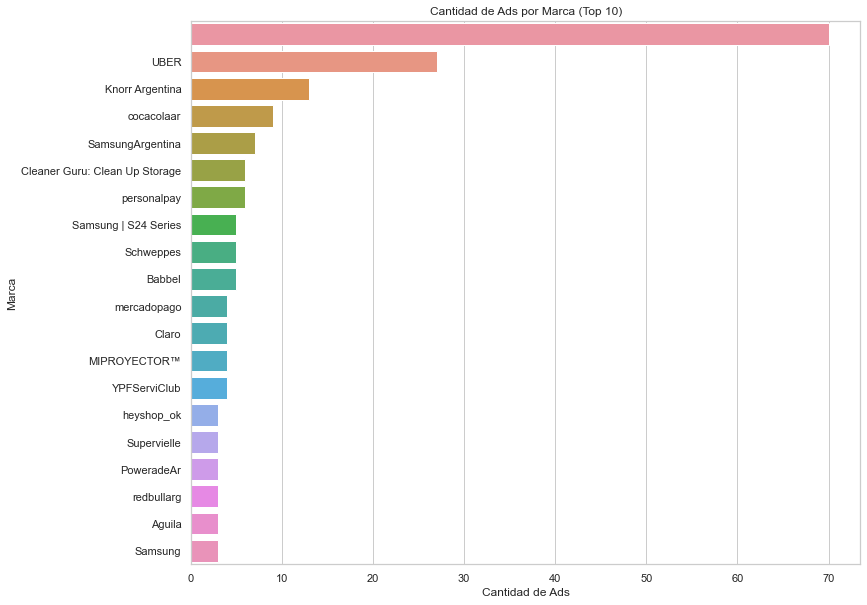

In [158]:
# Hago un barplot de la cantidad de ads por marca: tengo muchos Ads los cuales no tiene una marca asociada
plt.figure(figsize=(12, 10))
sns.countplot(y='brand_name', data=ads_df, order=ads_df['brand_name'].value_counts().head(20).index)
plt.title('Cantidad de Ads por Marca (Top 10)')
plt.xlabel('Cantidad de Ads')
plt.ylabel('Marca')
plt.show();

#### Costo

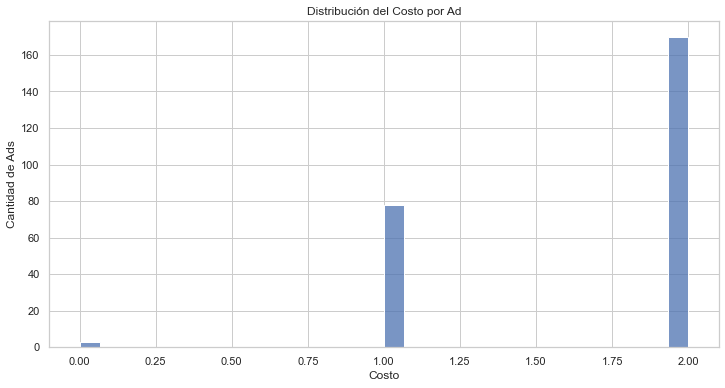

In [159]:
# Analicemos ahora como es la distribucion del costo por Ad: no parece ser muy representativa de nada. Debe ser una categorizacion de TikTok
plt.figure(figsize=(12, 6))
sns.histplot(ads_df['cost'], bins=30)
plt.title('Distribución del Costo por Ad')
plt.xlabel('Costo')
plt.ylabel('Cantidad de Ads')
plt.show();

#### CTR

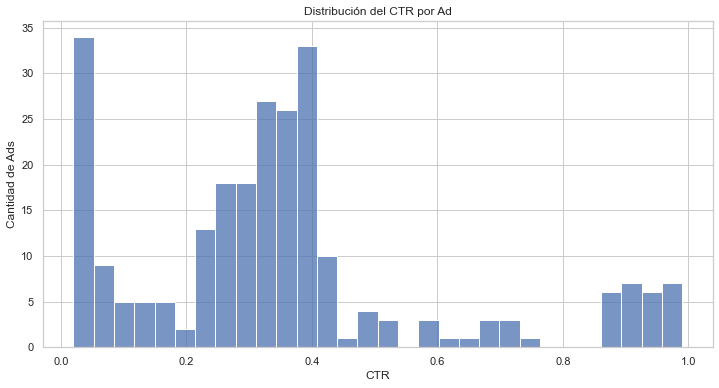

In [160]:
#Analicemos ahora como es la distribucion del ctr
#Aca si hay una distribucion interesante, hay que si hay alguna variable que explique el CTR
plt.figure(figsize=(12, 6))
sns.histplot(ads_df['ctr'], bins=30)
plt.title('Distribución del CTR por Ad')
plt.xlabel('CTR')
plt.ylabel('Cantidad de Ads')
plt.show();

In [161]:
ads_df['industry.parent.value'].value_counts()

industry.parent.value
Apps                  128
Food & Beverage        75
Tech & Electronics     48
Name: count, dtype: int64

/Users/camilojaureguiberry/anaconda3/envs/trendradar/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


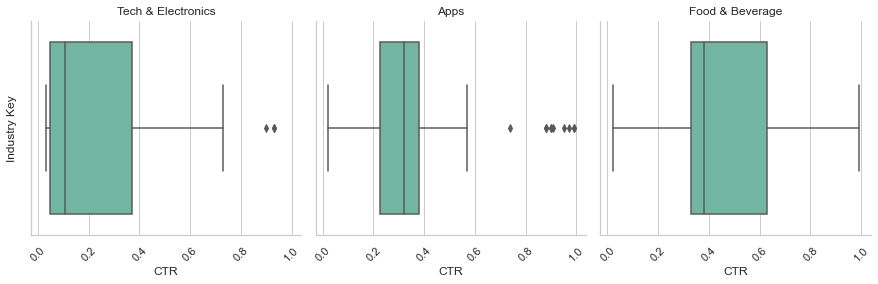

In [162]:
#Tratemos de explicar el CTR por industria, quizas algunas son mas performantes que otras por naturaleza
#Efectivamente, Tech & Electronics tiene menor CTR que Food & Beverage
sns.set(style="whitegrid")

g = sns.FacetGrid(ads_df, col="industry.parent.value", col_wrap=4, height=4)
g.map(sns.boxplot, "ctr", order=ads_df['industry.parent.value'].unique(), palette="Set2")

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_xlabel('CTR')
    ax.set_ylabel('Industry Key')

g.set_titles(col_template="{col_name}", row_template="{row_name}", size=12)
plt.show();

In [163]:
ads_df['objective.value'].value_counts()

objective.value
Video Views        98
Reach              71
Conversions        41
Traffic            33
App Installs        7
Lead Generation     1
Name: count, dtype: int64

/Users/camilojaureguiberry/anaconda3/envs/trendradar/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


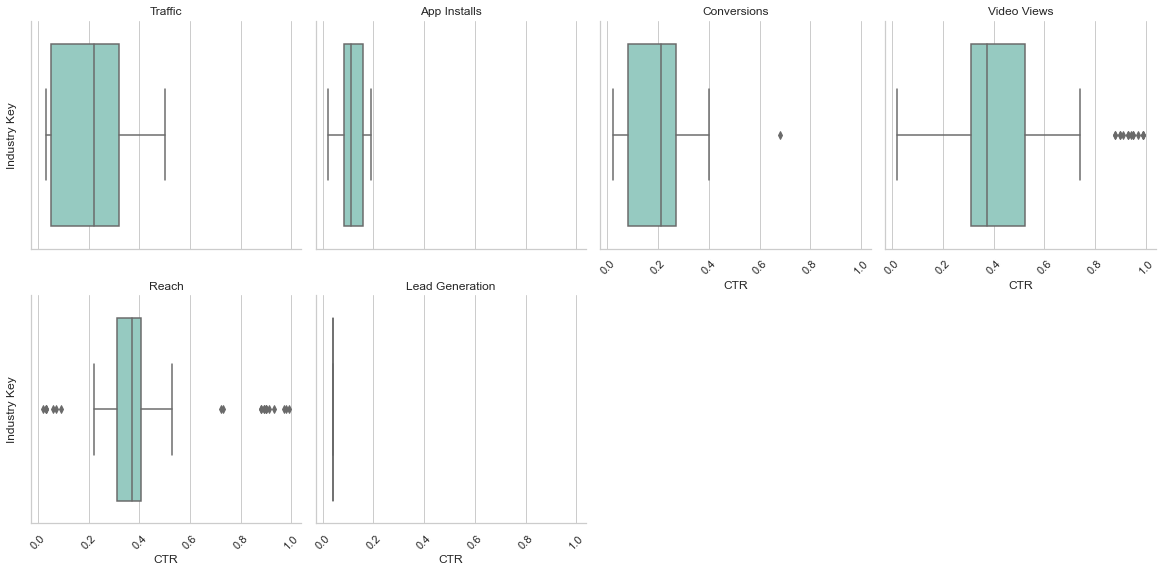

In [164]:
#Vamos a ver lo mismo, pero por objetivo de la campaña
#Efectivamente, el objetivo de la campaña influye en el CTR
#Curiosamente, tienen mejor CTR las campañas de Views que las de Installs y Conversion

sns.set(style="whitegrid")

g = sns.FacetGrid(ads_df, col="objective.value", col_wrap=4, height=4)
g.map(sns.boxplot, "ctr", order=ads_df['objective.value'].unique(), palette="Set3")

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_xlabel('CTR')
    ax.set_ylabel('Industry Key')

g.set_titles(col_template="{col_name}", row_template="{row_name}", size=12)
plt.show();

#### Favorite

In [165]:
#Falo
ads_df['favorite'].value_counts()

favorite
False    251
Name: count, dtype: int64

#### Like

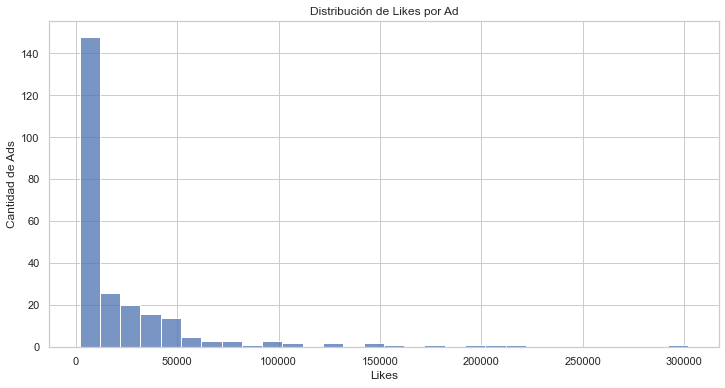

In [166]:
#Veamos la distribucion de likes por Ad
#Tipica distribucion de likes, bien sesgada a la derecha
#Hay Ads con 300k de likes

plt.figure(figsize=(12, 6))
sns.histplot(ads_df['like'], bins=30)
plt.title('Distribución de Likes por Ad')
plt.xlabel('Likes')
plt.ylabel('Cantidad de Ads')
plt.show();

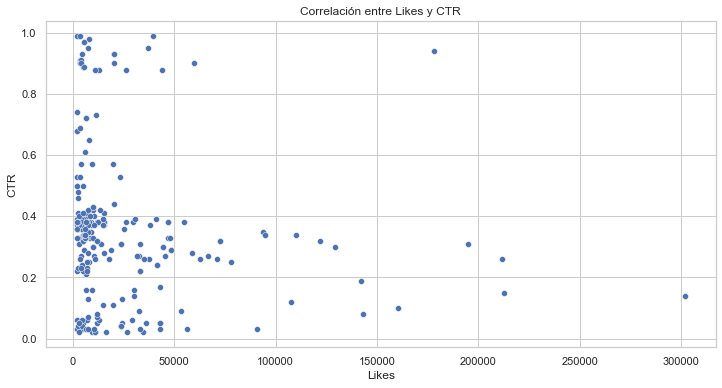

In [167]:
#Hay correlacion entre likes y CTR?
#No parece haber correlacion entre likes y CTR

plt.figure(figsize=(12, 6))
sns.scatterplot(x='like', y='ctr', data=ads_df)
plt.title('Correlación entre Likes y CTR')
plt.xlabel('Likes')
plt.ylabel('CTR')
plt.show();

/Users/camilojaureguiberry/anaconda3/envs/trendradar/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


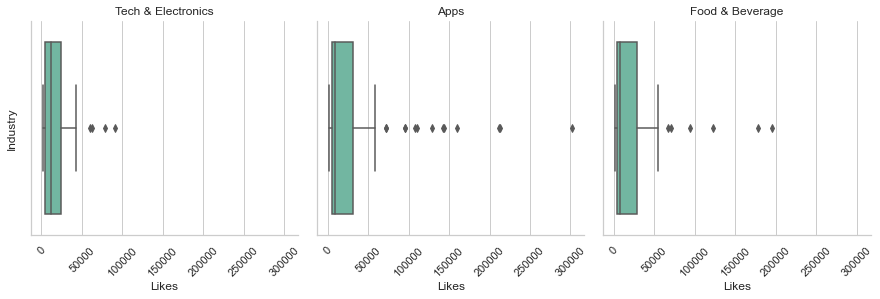

In [168]:
#Veamos los likes por industria
#Mas o menos lo mismo para todas las industrias

sns.set(style="whitegrid")

g = sns.FacetGrid(ads_df, col="industry.parent.value", col_wrap=4, height=4)
g.map(sns.boxplot, "like", order=ads_df['industry.parent.value'].unique(), palette="Set2")

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_xlabel('Likes')
    ax.set_ylabel('Industry')

g.set_titles(col_template="{col_name}", row_template="{row_name}", size=12)
plt.show();

/Users/camilojaureguiberry/anaconda3/envs/trendradar/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


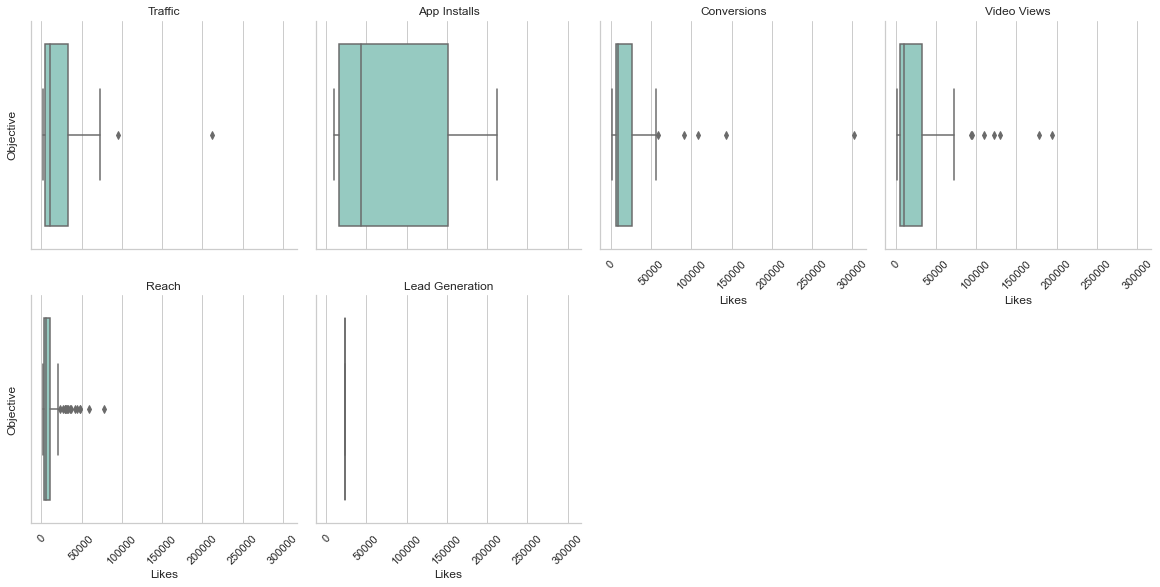

In [169]:
#Y por objetivo de la campaña?
#Salvo Apps Installs, el resto tiene distribuciones similares

sns.set(style="whitegrid")

g = sns.FacetGrid(ads_df, col="objective.value", col_wrap=4, height=4)
g.map(sns.boxplot, "like", order=ads_df['objective.value'].unique(), palette="Set3")

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.set_xlabel('Likes')
    ax.set_ylabel('Objective')

g.set_titles(col_template="{col_name}", row_template="{row_name}", size=12)
plt.show();

#### Objective

In [171]:
ads_df['objective.value'].value_counts()

objective.value
Video Views        98
Reach              71
Conversions        41
Traffic            33
App Installs        7
Lead Generation     1
Name: count, dtype: int64

In [172]:
#Viendolo bien, hay muy pocos casos de Apps Installs y de Lead Generation, los voy a eliminar del dataset
ads_df = ads_df[~ads_df['objective.value'].isin(['App Installs', 'Lead Generation'])]


#### Industry

In [173]:
ads_df['industry.parent.value'].value_counts()  

industry.parent.value
Apps                  121
Food & Beverage        75
Tech & Electronics     47
Name: count, dtype: int64

### Analisis de la frecuencia de aparición de cada elemento detectado.

In [174]:
ads_df['video_unique_detections']

0      [train, car, person, skateboard, cell phone, b...
1                                          [car, person]
2                                               [person]
3                                               [person]
4                           [laptop, person, cell phone]
                             ...                        
245                                       [cake, person]
246              [cat, tv, person, tie, cell phone, dog]
247                                             [person]
248                                   [sandwich, person]
249                                               [kite]
Name: video_unique_detections, Length: 243, dtype: object

In [175]:
detections_frequency = defaultdict(int)

for index, row in ads_df.iterrows():
    if isinstance(row['video_unique_detections'], list) and row['video_unique_detections']:
        for detection in row['video_unique_detections']:
            detections_frequency[detection] += 1

detections_frequency_df = pd.DataFrame(list(detections_frequency.items()), columns=['Elemento', 'Frecuencia'])

detections_frequency_df = detections_frequency_df.sort_values(by='Frecuencia', ascending=False)

detections_frequency_df.head(10)

,Elemento,Frecuencia
2,person,214
4,cell phone,77
20,cup,57
10,bottle,42
25,dining table,39
37,bowl,36
19,chair,29
35,book,26
1,car,25
6,laptop,23


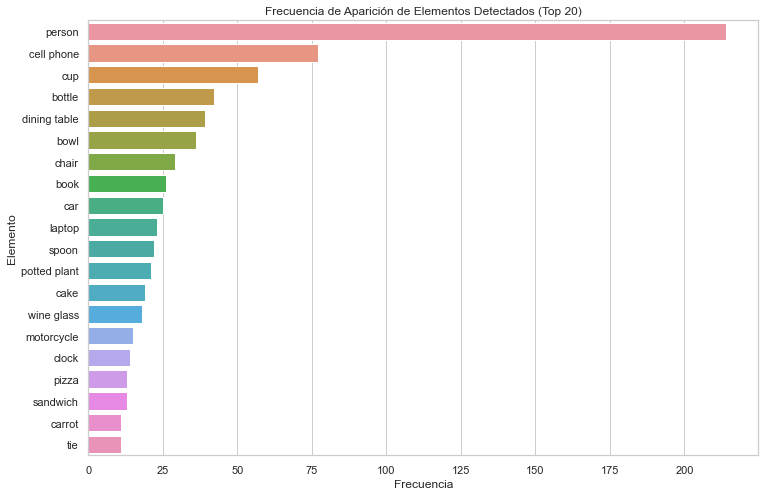

In [176]:

#Grafico la frecuencia de aparición de cada elemento detectado
plt.figure(figsize=(12, 8))
sns.barplot(x='Frecuencia', y='Elemento', data=detections_frequency_df.head(20))
plt.title('Frecuencia de Aparición de Elementos Detectados (Top 20)')
plt.xlabel('Frecuencia')
plt.ylabel('Elemento')
plt.show();

### Frequencia de elementos detectados por Objetivo de campaña

In [195]:
def plot_detection_frequencies(df, analysis_var, relative=False):
    """
    Genera un heatmap de la frecuencia de detecciones por una variable de análisis.
    
    Parámetros:
    - df: DataFrame desde donde consumir la data.
    - analysis_var: La variable contra la que queremos hacer el análisis de presencia de detecciones.
    - relative: Booleano que indica si queremos ver los valores relativos a la frecuencia total.
    
    Retorno:
    - None. La función genera y muestra un heatmap.
    """
    # Crear un diccionario de diccionarios para guardar la frecuencia de cada elemento detectado
    detections_frequency_by_var = defaultdict(lambda: defaultdict(int))

    # Recorrer cada fila del dataframe
    for index, row in df.iterrows():
        var_value = row[analysis_var]
        # Verificar si 'video_unique_detections' no es nulo ni está vacío
        if isinstance(row['video_unique_detections'], list) and row['video_unique_detections']:
            # Recorrer cada elemento detectado
            for detection in row['video_unique_detections']:
                # Incrementar la frecuencia de ese elemento para el valor de la variable correspondiente
                detections_frequency_by_var[var_value][detection] += 1

    # Convertir el diccionario de diccionarios en un DataFrame
    data = []
    for var_value, detections in detections_frequency_by_var.items():
        for detection, frequency in detections.items():
            data.append({'Variable': var_value, 'Detection': detection, 'Frequency': frequency})

    detections_frequency_df = pd.DataFrame(data)

    # Crear un cuadro de doble entrada (tabla de contingencia)
    pivot_table = detections_frequency_df.pivot_table(values='Frequency', index='Detection', columns='Variable', fill_value=0)

    # Añadir una columna "Frecuencia Total"
    pivot_table['Frecuencia Total'] = pivot_table.sum(axis=1)

    if relative:
        # Calcular los valores relativos a la frecuencia total para el resto de las columnas
        relative_pivot_table = pivot_table.div(pivot_table['Frecuencia Total'], axis=0)
        # Reemplazar la columna "Frecuencia Total" con los valores absolutos
        relative_pivot_table['Frecuencia Total'] = pivot_table['Frecuencia Total']
        pivot_table = relative_pivot_table

    # Graficar el cuadro de doble entrada como un mapa de calor
    plt.figure(figsize=(16, 16))
    sns.heatmap(pivot_table, annot=True, fmt='.2f' if relative else 'd', cmap='YlGnBu')
    plt.title(f'Frecuencia de Elementos Detectados por {analysis_var}')
    plt.xlabel(analysis_var)
    plt.ylabel('Elemento Detectado')
    plt.show()

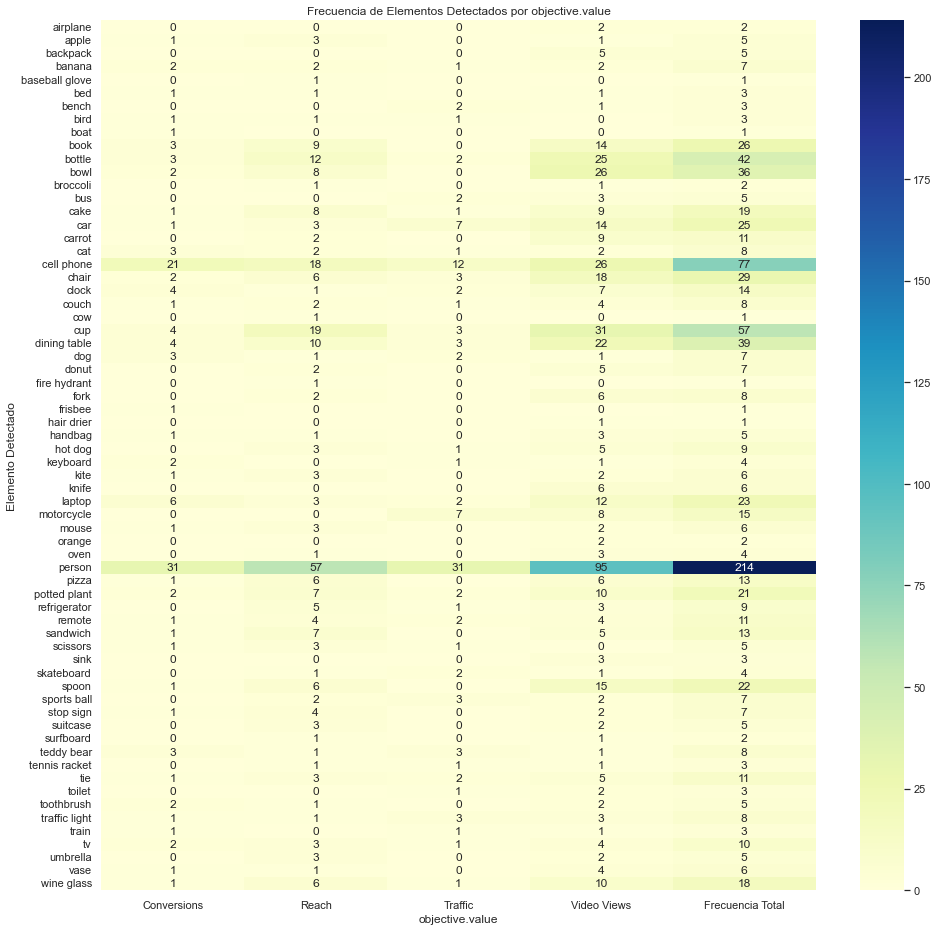

In [198]:
plot_detection_frequencies(ads_df, 'objective.value', relative=False)

1. Person:
- El elemento “person” es, con diferencia, el más frecuente en todos los tipos de campañas.
- Aparece especialmente en campañas de “Reach” (57 veces) y “Video Views” (96 veces), lo que sugiere que los anuncios que buscan maximizar el alcance y las vistas de video tienden a incluir personas con mayor frecuencia.
2.	Cell Phone:
- El “cell phone” también es un elemento muy común, especialmente en campañas de “Reach” (18 veces) y “Video Views” (26 veces).
- Esto podría indicar que los anuncios que buscan maximizar el alcance y las vistas de video frecuentemente presentan teléfonos celulares, posiblemente debido a la relevancia de estos dispositivos en la vida diaria.
3.	Chair y Cup:
- Ambos elementos son relativamente frecuentes, particularmente en campañas de “Reach” y “Video Views”.
- “Chair” aparece 18 veces en “Video Views” y 6 veces en “Reach”.
- “Cup” aparece 31 veces en “Video Views” y 19 veces en “Conversions”.
4.	Book y Bottle:
- “Book” y “Bottle” aparecen con bastante frecuencia en campañas de “Reach” y “Video Views”.
- “Book” aparece 9 veces en “Reach” y 14 veces en “Video Views”.
- “Bottle” aparece 26 veces en “Video Views”.
5.	Laptop:
- “Laptop” es un elemento destacado en campañas de “Traffic” (12 veces) y “Video Views” (6 veces), indicando su relevancia en anuncios que buscan generar tráfico y vistas de video.
6.	Pizza y Dog:
- “Pizza” aparece notablemente en campañas de “Traffic” (10 veces) y “Video Views” (7 veces).
- “Dog” aparece con frecuencia en “Video Views” (5 veces) y en “Conversions” (3 veces).
7.	Bus y Train:
- “Bus” y “Train” aparecen principalmente en campañas de “Video Views”.
- “Bus” aparece 26 veces y “Train” 2 veces en “Video Views”.

### Conclusiones

- Presencia Humana: La alta frecuencia de “person” sugiere que la presencia humana es un elemento clave en los anuncios, independientemente del objetivo de la campaña.
- Relevancia de Dispositivos Electrónicos: Elementos como “cell phone” y “laptop” son comunes, indicando la importancia de estos dispositivos en los anuncios, especialmente en campañas de “Reach” y “Video Views”.
- Objetos de Uso Diario: Elementos como “chair”, “cup”, “book”, y “bottle” son frecuentes, sugiriendo que los anuncios a menudo incluyen objetos de uso diario para conectar con la audiencia.

### Frequencia de elementos detectados por Industria

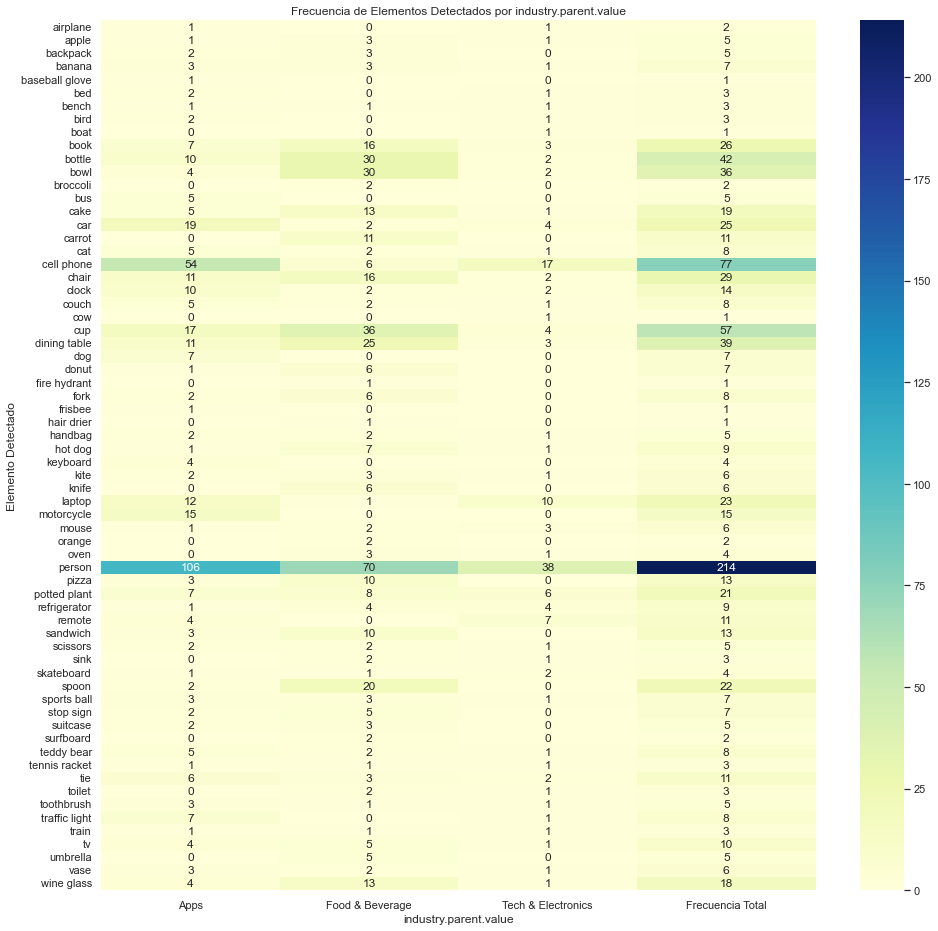

In [199]:
plot_detection_frequencies(ads_df, 'industry.parent.value', relative=False)

1.	Person:
- El elemento “person” es, de nuevo, el más frecuente en todas las industrias.
- Aparece especialmente en “Food & Beverage” (70 veces) y “Tech & Electronics” (38 veces), lo que sugiere que los anuncios de estas industrias tienden a incluir personas con mayor frecuencia.
2.	Cup:
- “Cup” es notablemente frecuente en la industria de “Food & Beverage” (36 veces).
- Esto indica que los anuncios en esta industria a menudo presentan tazas, posiblemente debido a la asociación con bebidas.
3.	Chair y Cell Phone:
- “Chair” y “Cell Phone” son comunes en “Tech & Electronics” y “Food & Beverage”.
- “Chair” aparece 16 veces en “Tech & Electronics” y 11 veces en “Food & Beverage”.
- “Cell Phone” aparece 17 veces en “Tech & Electronics”.
4.	Dining Table y Book:
- “Dining Table” es frecuente en “Food & Beverage” (25 veces), indicando su relevancia en anuncios relacionados con comida y bebida.
- “Book” aparece 16 veces en “Food & Beverage”.
5.	Motorcycle:
- “Motorcycle” es un elemento destacado en la industria de “Apps” (15 veces), sugiriendo su relevancia en anuncios de aplicaciones, posiblemente relacionadas con transporte o movilidad.
6.	Bottle y Bowl:
- “Bottle” y “Bowl” son frecuentes en “Food & Beverage”.
- “Bottle” aparece 30 veces y “Bowl” 30 veces en “Food & Beverage”.
7.	Pizza y Dog:
- “Pizza” y “Dog” son elementos que destacan en “Food & Beverage”.
- “Pizza” aparece 8 veces y “Dog” 6 veces en “Food & Beverage”.

### Conclusiones

- Presencia Humana: Al igual que en el análisis por objetivo de campaña, la presencia humana es un elemento clave en los anuncios de todas las industrias.
- Relevancia de Elementos de Comida y Bebida: La industria de “Food & Beverage” presenta una alta frecuencia de elementos relacionados con la comida y la bebida, como “cup”, “dining table”, “bottle”, y “bowl”.
- Dispositivos Electrónicos: En “Tech & Electronics”, elementos como “cell phone” y “chair” son comunes, indicando la importancia de estos dispositivos en los anuncios.
- Elementos Diversos en Aplicaciones: La industria de “Apps” muestra una alta frecuencia de “motorcycle”, sugiriendo que los anuncios de aplicaciones pueden incluir elementos de transporte o movilidad.

#### Top Performing Ads y sus elementos detectados

Quiero saber, si hay alguna diferencia en la composicion de elementos detectados de aquellos Ads top performing (decil superior de CTR o Likes) contra el resto

In [200]:
top_percentage = 10

# Calculo el umbral de CTR para el top porcentaje y filtro los Ads
ctr_threshold = ads_df['ctr'].quantile(1 - top_percentage / 100)
top_ads_df = ads_df[ads_df['ctr'] >= ctr_threshold]

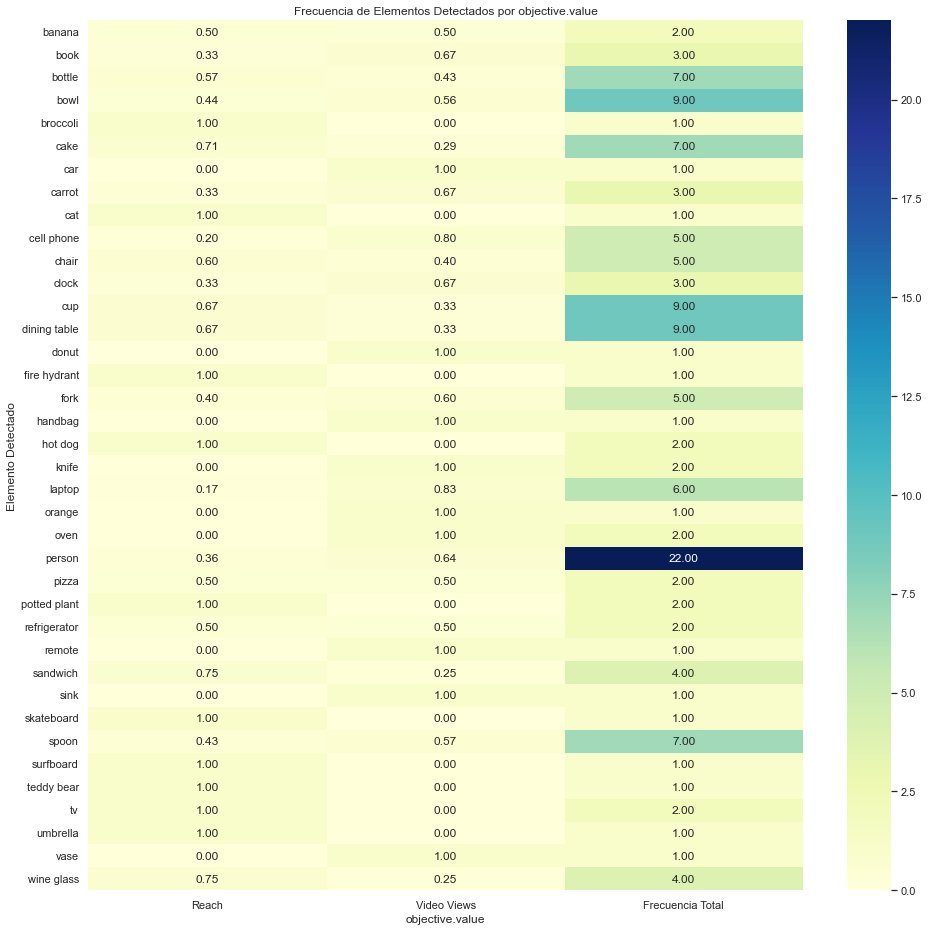